<a href="https://colab.research.google.com/github/camilla-lima0/17.1-Comparing-Classifiers/blob/main/prompt_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Goal & Business Understanding

The business problem is to improve the efficiency of a bank's telemarketing campaign. The bank wants to predict which clients are most likely to subscribe to a term deposit when contacted. A successful model will allow the bank to save money and time by focusing its efforts on high-potential customers, thereby increasing the overall conversion rate.


** IMPORTING LIBRARIES AND DATA **

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, roc_auc_score, f1_score, accuracy_score
from sklearn.inspection import permutation_importance
import time
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = pd.read_csv('/content/bank-additional-full.csv', sep = ';')

** DATA CLEAN UP **

In [ ]:
df = df.drop(['nr.employed', 'pdays'], axis=1)
# dropping as its numeric but repetitive for a quarter and pdays has 999 as a definition of no-contact

# same for all qrtly data
df = df.drop(['emp.var.rate', 'cons.price.idx','cons.conf.idx', 'euribor3m','duration'], axis=1)


In [ ]:
df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,previous,poutcome,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,0,nonexistent,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,0,nonexistent,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,0,nonexistent,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,0,nonexistent,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,0,nonexistent,0
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,1,0,nonexistent,0
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,1,0,nonexistent,0
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,1,0,nonexistent,0
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,1,0,nonexistent,0
9,25,services,single,high.school,no,yes,no,telephone,may,mon,1,0,nonexistent,0


In [ ]:
#Make Variable Binary
df['y'] = df['y'].map({'no': 0, 'yes': 1})

#Split X and Y
X = df.drop('y', axis=1)
y = df['y']

#Identify Features
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

In [ ]:
#One Hot Encoding
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale numeric features
scaler = StandardScaler()

# Fit on training data and transform both train and test data
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])


** MODELING **

In [ ]:

# CALCULATE BASELINE #

dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train, y_train)
y_pred_dummy = dummy_clf.predict(X_test)

baseline_f1 = f1_score(y_test, y_pred_dummy)
baseline_auc = roc_auc_score(y_test, dummy_clf.predict_proba(X_test)[:, 1])
print(f"Baseline F1-Score: {baseline_f1:.4f}")
print(f"Baseline AUC: {baseline_auc:.4f}")


Baseline F1-Score: 0.1173
Baseline AUC: 0.5031


In [ ]:

# TEST MODELS #

results = {}
best_models = {}

models_grid = {
    "Logistic Regression": {
        "model": LogisticRegression(solver='liblinear', max_iter=1000, random_state=42),
        "params": {"C": [0.01, 0.1, 1, 10]}
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(),
        "params": {"n_neighbors": [5, 9, 13]}
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=42),
        "params": {"max_depth": [5, 10, None], "min_samples_leaf": [1, 2, 4]}
    }
}

for model_name, config in models_grid.items():
    print(f"\nTraining {model_name}...")
    grid_search = GridSearchCV(config["model"], config["params"], cv=5, scoring='f1', n_jobs=-1, verbose=1)

    start_time = time.time()
    grid_search.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time

    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model # Store the best model
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Training time for {model_name}: {training_time:.2f} seconds")

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else [0.5] * len(y_test)
    results[model_name] = {
        "Training Time (s)": training_time,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_proba),
        "Precision": float(classification_report(y_test, y_pred, output_dict=True, zero_division=0)['1']['precision']),
        "Recall": float(classification_report(y_test, y_pred, output_dict=True, zero_division=0)['1']['recall'])
    }




Training Logistic Regression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best parameters for Logistic Regression: {'C': 10}
Training time for Logistic Regression: 4.16 seconds

Training K-Nearest Neighbors...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters for K-Nearest Neighbors: {'n_neighbors': 5}
Training time for K-Nearest Neighbors: 21.73 seconds

Training Decision Tree...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 1}
Training time for Decision Tree: 10.05 seconds


In [ ]:
# TEST MODELS: PART 2: SVM #


# Create a smaller subsample of the training data for faster hyperparameter searching
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train, train_size=0.2, random_state=42, stratify=y_train
)
# Searching for best RBF kernel parameters

svc_rbf = SVC(probability=True, random_state=42, cache_size=500)
param_dist_rbf = {
    'C': [0.1, 1, 10, 50],
    'gamma': ['scale', 'auto']
}
random_search_rbf = RandomizedSearchCV(
    svc_rbf, param_distributions=param_dist_rbf, n_iter=4, cv=3, scoring='f1',
    n_jobs=-1, random_state=42, verbose=1
)
random_search_rbf.fit(X_train_sample, y_train_sample)
best_rbf_score = random_search_rbf.best_score_



--- 3. Training SVM with Optimization ---
Using a subsample of 5766 for SVM hyperparameter search (20% of training data).

Searching for best RBF kernel parameters...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best F1-score for RBF kernel on subsample: 0.2887


In [ ]:
# Searching for best Linear kernel parameters

svc_linear = LinearSVC(dual='auto', random_state=42, max_iter=2000) # dual='auto' is safer
param_dist_linear = {'C': [0.01, 0.1, 1, 10]}

grid_search_linear = GridSearchCV(
    svc_linear, param_grid=param_dist_linear, cv=3, scoring='f1', n_jobs=-1, verbose=1
)
grid_search_linear.fit(X_train_sample, y_train_sample)
best_linear_score = grid_search_linear.best_score_



Searching for best Linear kernel parameters...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best F1-score for Linear kernel on subsample: 0.2772


In [ ]:
# Select the best SVM

start_time_svm = time.time()

if best_rbf_score > best_linear_score:
    print("RBF kernel performed better. Retraining the best RBF model.")
    best_svm_params = random_search_rbf.best_params_
    best_svm = SVC(probability=True, random_state=42, **best_svm_params)
else:
    print("Linear kernel performed better. Retraining the best Linear model.")
    best_svm_params = grid_search_linear.best_params_
    best_svm = LinearSVC(dual='auto', random_state=42, **best_svm_params)


Retraining the best overall SVM on the full training dataset...
RBF kernel performed better. Retraining the best RBF model.


In [12]:
best_svm.fit(X_train, y_train)

end_time_svm = time.time()
training_time_svm = end_time_svm - start_time_svm
best_models["SVM"] = best_svm

print(f"Best overall SVM parameters: {best_svm.get_params()}")
print(f"Final training time for SVM: {training_time_svm:.2f} seconds")

# CHECK BEST SVM

y_pred_svm = best_svm.predict(X_test)

if hasattr(best_svm, "predict_proba"):
    y_proba_svm = best_svm.predict_proba(X_test)[:, 1]
else:
    y_proba_svm = best_svm.decision_function(X_test)
    y_proba_svm = (y_proba_svm - y_proba_svm.min()) / (y_proba_svm.max() - y_proba_svm.min())


results["SVM"] = {
    "Training Time (s)": training_time_svm,
    "Accuracy": accuracy_score(y_test, y_pred_svm),
    "F1-Score": f1_score(y_test, y_pred_svm),
    "AUC": roc_auc_score(y_test, y_proba_svm),
    "Precision": float(classification_report(y_test, y_pred_svm, output_dict=True, zero_division=0)['1']['precision']),
    "Recall": float(classification_report(y_test, y_pred_svm, output_dict=True, zero_division=0)['1']['recall'])
}



Best overall SVM parameters: {'C': 50, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Final training time for SVM: 755.27 seconds


In [13]:
## MODEL COMPARISON ##

results_df = pd.DataFrame(results).T.round(4)
baseline_metrics = {
    "Training Time (s)": 0.0,
    "Accuracy": accuracy_score(y_test, y_pred_dummy),
    "F1-Score": baseline_f1,
    "AUC": baseline_auc,
    "Precision": float(classification_report(y_test, y_pred_dummy, output_dict=True, zero_division=0)['1']['precision']),
    "Recall": float(classification_report(y_test, y_pred_dummy, output_dict=True, zero_division=0)['1']['recall'])
}
results_df.loc['Baseline (Dummy)'] = baseline_metrics
results_df['Interpretability'] = ['High', 'Low', 'Very High', 'Low', 'N/A']
results_df = results_df.sort_values(by="F1-Score", ascending=False)

cols = ['Training Time (s)'] + [col for col in results_df.columns if col != 'Training Time (s)']
results_df = results_df[cols]

print("Final Results Summary Table:")
print(results_df)

Final Results Summary Table:
                     Training Time (s)  Accuracy  F1-Score       AUC  \
Decision Tree                   4.4288  0.894200  0.316100  0.712700   
SVM                           755.2673  0.899500  0.291900  0.686200   
K-Nearest Neighbors            17.2706  0.890100  0.276100  0.684100   
Logistic Regression             5.0841  0.898100  0.273500  0.770200   
Baseline (Dummy)                0.0000  0.802703  0.117306  0.503105   

                     Precision    Recall Interpretability  
Decision Tree         0.581900  0.217000        Very High  
SVM                   0.707200  0.183900              Low  
K-Nearest Neighbors   0.535100  0.186100              Low  
Logistic Regression   0.695000  0.170300             High  
Baseline (Dummy)      0.118248  0.116379              N/A  



--- 5. Visualizing the Best Decision Tree ---


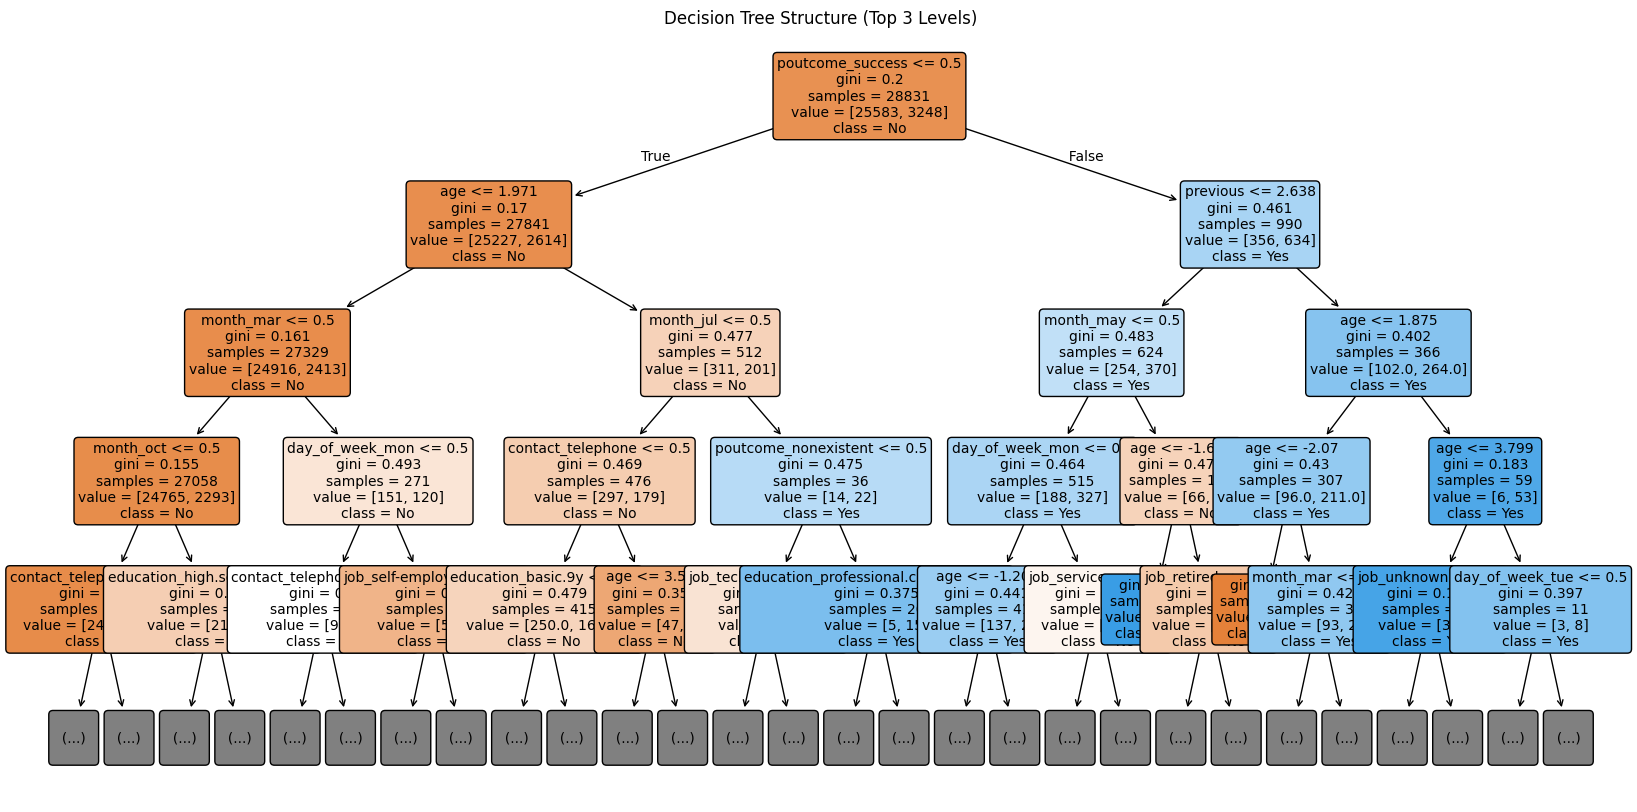

In [14]:

## DECISION TREE VISUALIZATION ##


print("\n--- 5. Visualizing the Best Decision Tree ---")
best_dt_model = best_models.get("Decision Tree")
if best_dt_model:
    plt.figure(figsize=(20,10))
    plot_tree(best_dt_model,
              feature_names=X.columns,
              class_names=['No', 'Yes'],
              filled=True,
              rounded=True,
              max_depth=4,
              fontsize=10)
    plt.title("Decision Tree Structure (Top 3 Levels)")
    plt.show()
else:
    print("Decision Tree model not found in the trained models.")



--- 6. Visualizing Feature Importances for Best Models ---


/tmp/ipython-input-425005314.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


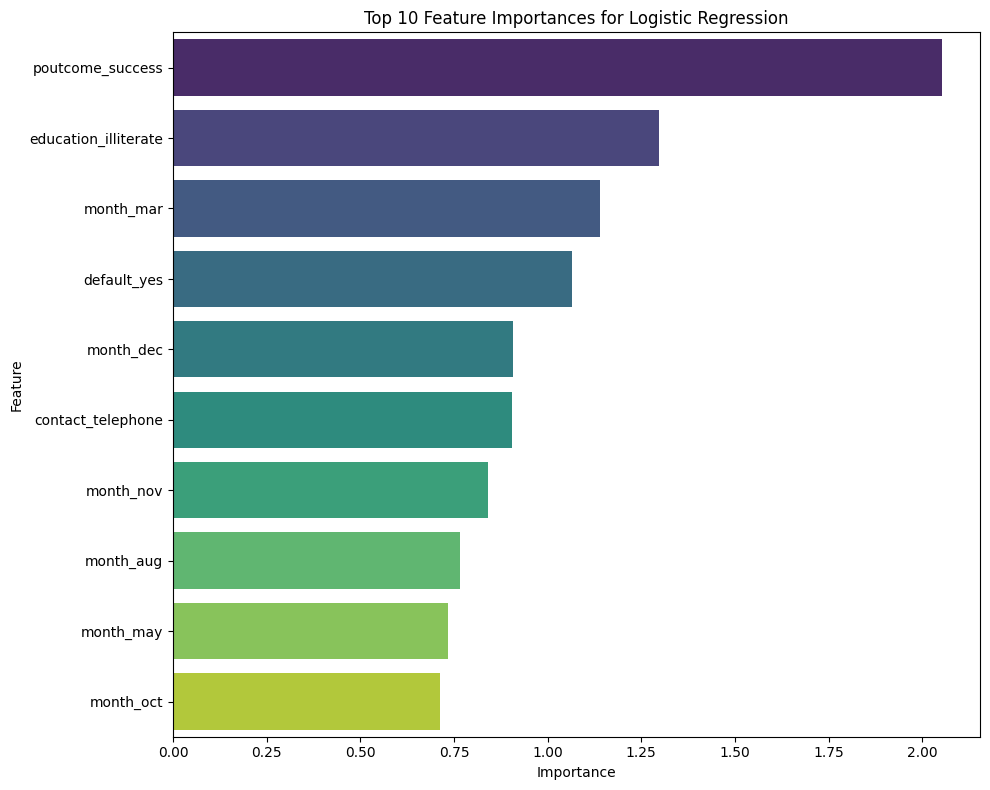


Calculating Permutation Importance for K-Nearest Neighbors (this might take a moment)...


/tmp/ipython-input-425005314.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


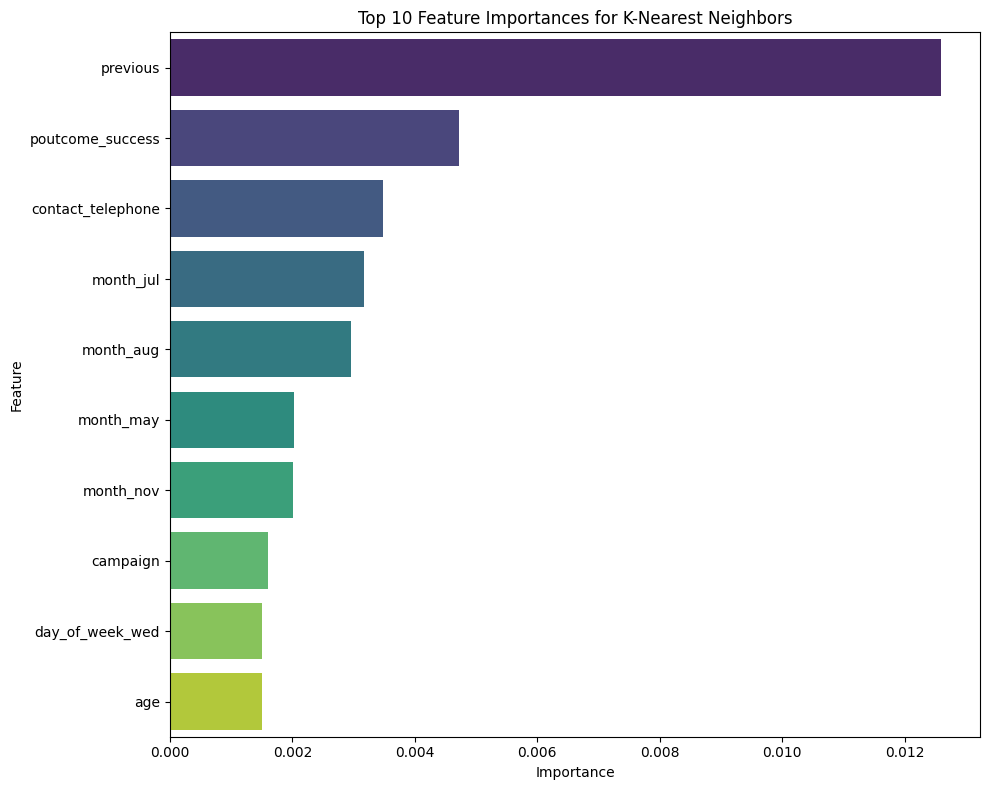

/tmp/ipython-input-425005314.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


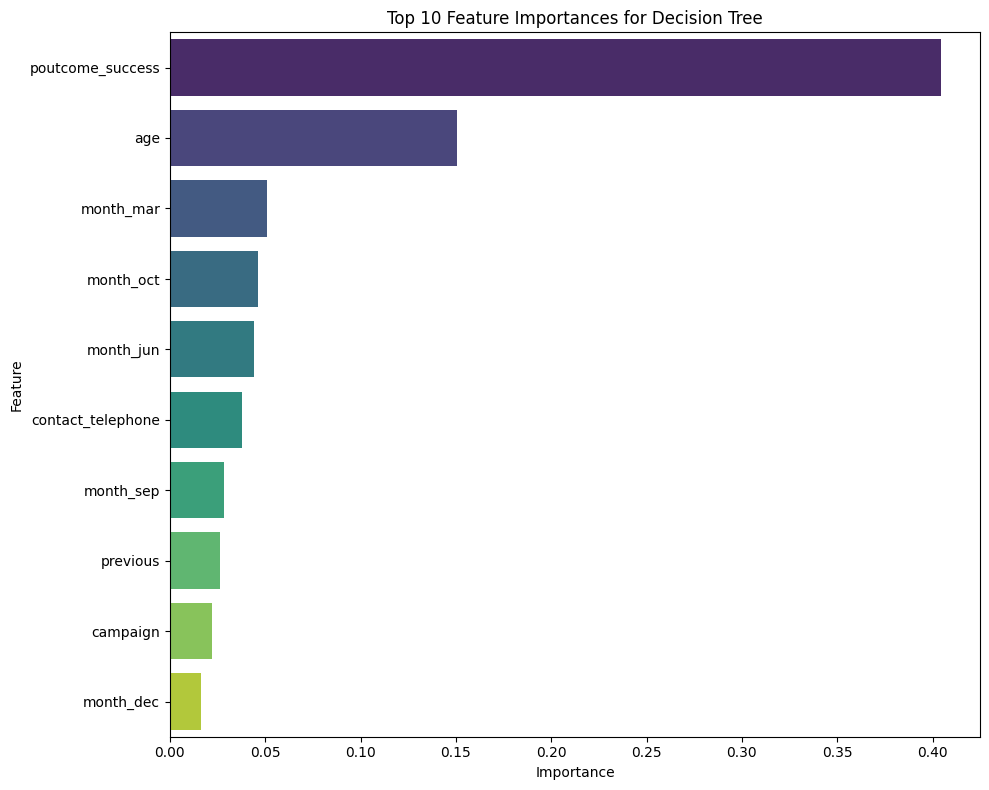


Calculating Permutation Importance for SVM (this might take a moment)...


/tmp/ipython-input-425005314.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


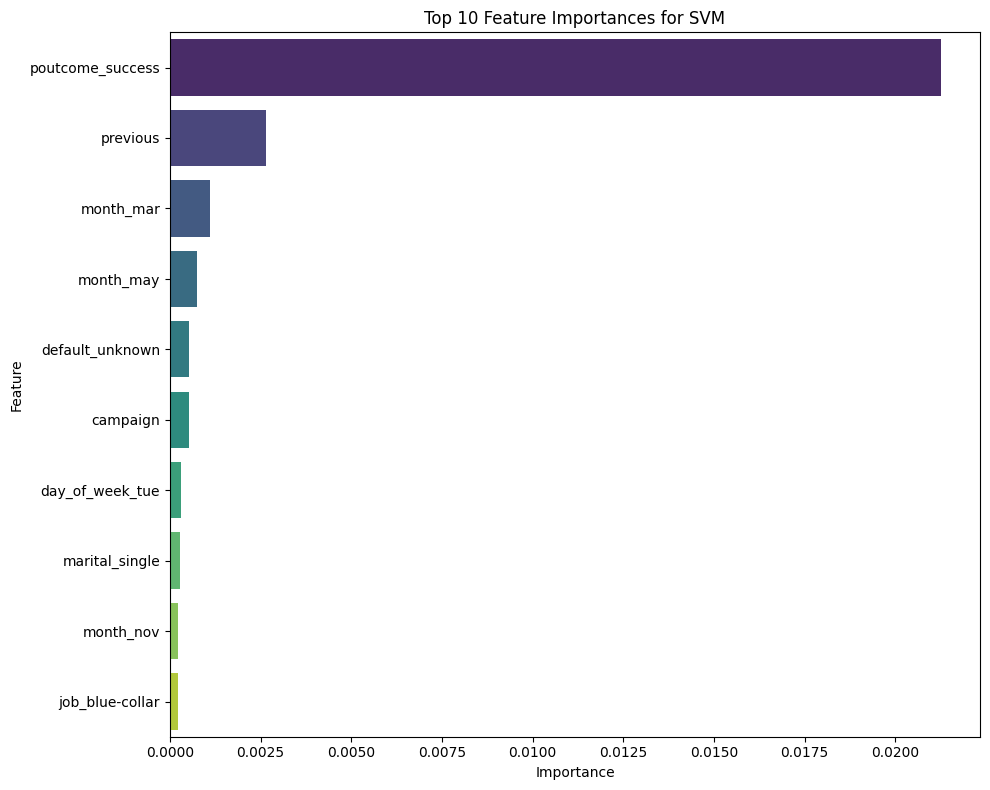

In [15]:
# --- 6. FEATURE IMPORTANCE VISUALIZATION --- #
import seaborn as sns # Import seaborn for nicer plots

print("\n--- 6. Visualizing Feature Importances for Best Models ---")
feature_names = X.columns

for name, model in best_models.items():

    importances = None
    # --- For Linear Models (Logistic Regression, Linear SVC) ---
    if hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])

    # --- For Tree-Based Models ---
    elif hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_

    # --- For other models (KNN, RBF SVM) use Permutation Importance ---
    else:
        print(f"\nCalculating Permutation Importance for {name} (this might take a moment)...")
        perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
        importances = perm_importance.importances_mean

    # Create a DataFrame for plotting
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
    plt.title(f'Top 10 Feature Importances for {name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


In [17]:
## CONCLUSION AND RECOMMENDATION ##

# All models have pretty good accuracy but the decision tree is the best one given its f1 score.

# Decision Tree has the best F1 Score indicating it finds a good balance between
# not wasting money on people who won't subscribe (precision) and also not
# missing out potential customers (recall). The decision tree is also highly
# interpretable which makes it easier for the bank to further target their
# marketing campaigns. So we know that the following variables are the most
# important ones to predict if the customer will subscribe to a term deposit

# 1) Previous Campaign Success
# 2) Age
# 3) Month of Contact



##### Questions